South King County Opportunity Youth
===================
This project offers an updated estimate of the number of Opportunity Youth in South King County using the 2017 5-year American Community Survey. The SRP would like an update on the estimated number of OY in South King County. However, that estimation comes from a report that is over three years old. The task was to update the SRP on the current status of OY in South King County using updated data.

The data used to for updated opportunity youth can be found at https://data.census.gov/.

<h1>Importing Libraries and Database </h1>

In [8]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data import data_collection
%matplotlib inline

In [9]:
DBNAME = "opportunity_youth"

In [10]:
conn = psycopg2.connect(dbname=DBNAME)

### Query

We pull the data for the PUMAs (separate regions studied, defined by population and the edges of census tracts) that we are interested in.  We need employment information, education information, and ages.  We pull the data for everyone, not just opportunity youth so we can compare their prevalence to total population.

##### Choice of Regions

We decided to use 11610 - 11615 because on the PUMA_names look up table, they all say they are King Country South somewhere.  We also included 11604 because those are clearly south of the City of Seattle.  These pumas regions closely mirrored the school districts in the 2016 Road Map. 

##### Sample Weights

Finally, we pull the sample weights, since only a fraction of the population was polled for this dataset.

In [26]:
query = """
SELECT esr, schl education_attained, sch enrollment_status, agep age, pwgtp sample_weight
FROM pums_2017
where puma between '11610' and '11615'
or puma = '11604'
"""
df = pd.read_sql(query, conn)

#### Data Cleaning

##### Employment

For our employment data we want as complete a dataset as possible, so set missing values in esr to '3' with the assumption that missing values represent non-employed samples.

We made this choice for 2 reasons:

1. We assume folks are more likely to report that they are employed than if they are not.
2. We want to avoid under-countring our opportunity youths.

In [27]:
df['employed'] = 1
df.loc[(df.esr == '3') | (df.esr == '6'),'employed'] = 0
df.esr.fillna('3', inplace = True)
df.drop(columns = ['esr'], inplace = True)

In [13]:
df.to_csv('full_database.csv', index = False)

<h1>Estimating Population of Opportunity Youth</h1>
Another data frame was created to calculate the OY by puma using the same choices from above, but including the pumas. 

In [14]:
oy_df = pd.read_sql('''SELECT * 
FROM pums_2017
WHERE puma IN ('11612','11613','11614','11615','11604', '11610', '11611')
AND agep BETWEEN '16' AND '24'
AND esr IN ('3','6','NaN')
AND SCH IN ('0','1','NAN')
;''', conn)

A dataframe including all the youth was created as well 

In [17]:
#Query for all the youth aged 16-24
ty_df = pd.read_sql('''SELECT *
FROM pums_2017
WHERE puma IN ('11612','11613','11614','11615','11604', '11610', '11611')
AND agep BETWEEN '16' AND '24'
;''', conn)

In [15]:
#a list of the estimated population by each region and the total population for all 7 regions
population = oy_df.groupby('puma')['pwgtp'].sum()   # pwgtp was the weight each sample held 
estimated_population = sum(population)
print(f'The total population of OY in South King County is: {estimated_population}')

The total population of OY in South King County is: 11530.0


In [18]:
#a list of the youth by each region and the total youth population for all 7 regions
ty_population = ty_df.groupby('puma')['pwgtp'].sum()   # pwgtp was the weight each sample held 
ty_estimated_population = sum(ty_population)

<h1>Setting up data for graphing</h1>


The Names of the pumas were hardcoded into the dictionary using the information from [here](https://usa.ipums.org/). Latitude, longitude were also hardcoded into the dictionary because these values will not change. 

In [19]:
# dictionary of Puma number, and then sorting it by the OY population of each puma
# Used to organize the names of the puma which wasnt included in the dataframe
import operator
region_dic = {'11612': [population['11612'],'Federal Way,Des moines Cities & Vashon island', 47.3223, -122.3126, 110, ty_population['11612']],
 '11613': [population['11613'],'Kent City',47.3809, -122.2348, 34.43, ty_population['11613']],
 '11611': [population['11611'],'Burien, SeaTac, Tukwita Cities',47.4668, -122.3405, 31, ty_population['11611']],
 '11614': [population['11614'],'Auburn City & Lakeland', 47.3073, -122.2285, 35, ty_population['11614']],
 '11604': [population['11604'],'South East Seattle', 47.5923, -122.3022, 30.5, ty_population['11604']],
 '11615': [population['11615'],'Maple Valley, Covingtion and Enumclaw Cities', 47.3903, -122.0454, 18, ty_population['11615']],
 '11610': [population['11610'],'Renton City, Fairwood, Bryn Mawr and Skyway', 47.4797, -122.2079, 31, ty_population['11610']]}

sort_region_dic = dict(sorted(region_dic.items(), key=operator.itemgetter(1), reverse = True))

In [20]:
#created a list of the cities and populations that will be used for graphing
city_list = [item[1] for item in sort_region_dic.values()]  
estimated_population_region = [item[0] for item in sort_region_dic.values()] 
# adjusted city list so the string is on muliple lines in the graph
city_list_adj = [sub.replace(',',',\n').replace(' &',',\n') for sub in city_list]

<h1>Plotting Information</h1>
Created a bar graph comparing the Estimated Population per region
and a map showing these results

No handles with labels found to put in legend.


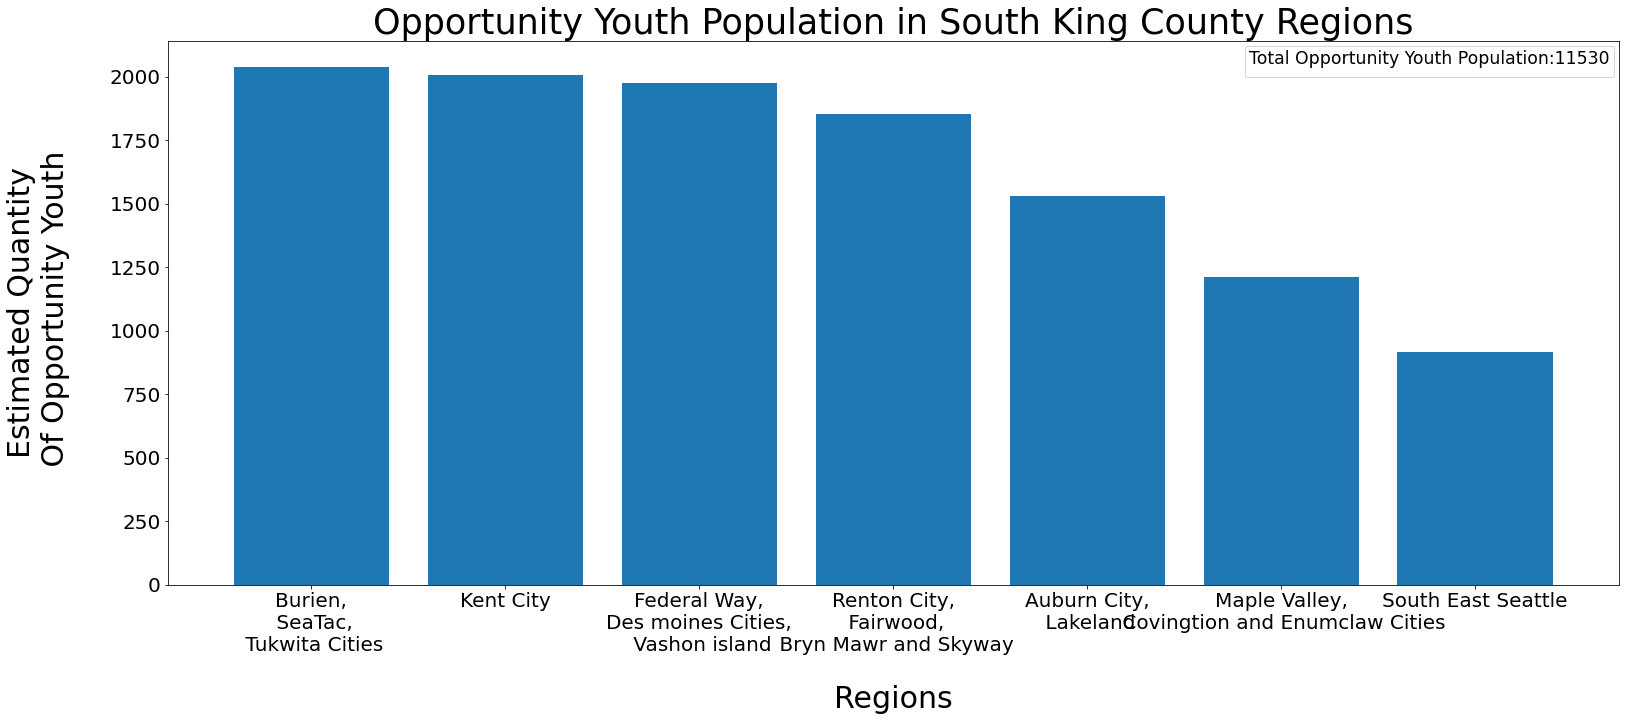

In [21]:
#Printing a Bar graph of the population estimate per each puma(region)
figure, ax = plt.subplots(1, 1, figsize = (26,10));

x = city_list_adj;
y = estimated_population_region;
ax.bar(x, y);


ax.set_ylabel('Estimated Quantity\n Of Opportunity Youth', fontsize = 30, rotation = 90, labelpad = 40);
ax.set_xlabel('Regions', fontsize = 30, labelpad = 30);
ax.set_title('Opportunity Youth Population in South King County Regions', fontsize = 35);
ax.set_xticklabels(city_list_adj, wrap = True);
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(title =f'Total Opportunity Youth Population:{int(estimated_population)}' , title_fontsize= 'xx-large', fancybox=True);      

<h1>Plotting the Map</h1>
We used Folium and to give a visualization comparing OY youth in each region by correlating circle size to OY.

In [22]:
#imported the following libraries to graph a map.
import folium
import pandas as pd
import branca as cm
from folium.plugins import FloatImage

In [23]:
#sorted values from dictionary into variables to be used for graphing pursposes
name = [i[1] for i in region_dic.values()]
population_values = [i[0] for i in region_dic.values()]
lat = [i[2] for i in region_dic.values()]
lon = [i[3] for i in region_dic.values()]

In [24]:
m = folium.Map(location=[47.45,-122.3321], zoom_start=11)

#loop through each lat,long and population. 
#
for i in range(0,len(region_dic.values())):
   folium.CircleMarker(
      location=[lat[i], lon[i]],
      popup= name[i] + ', \nPopulation:' + str(population_values[i]),
      radius=population_values[i]/20,
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)

#creates a legend in the upper left portion. 
colormap = cm.colormap.LinearColormap(colors=['blue','blue','blue','blue','blue'], index=[0,1000,2000,3000,4000],vmin=0,vmax=4000);
colormap.caption = 'POPULATION OF OPPORTUNITY YOUTH';
colormap.add_to(m);
m

In [28]:
opportunity_youth = pd.DataFrame()